# Compute background of the BlockModel with `empymod`

In [1]:
import empymod
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook
plt.style.use('ggplot')

## Load model and survey

In [3]:
survey = xr.load_dataset('../block_model_and_survey.nc', engine='h5netcdf')
survey

<xarray.Dataset>
Dimensions:  (x: 101)
Coordinates:
  * x        (x) float64 -1e+04 -9.8e+03 -9.6e+03 ... 9.6e+03 9.8e+03 1e+04
Data variables:
    line_1   (x) complex128 0j 0j 0j 0j 0j 0j 0j 0j ... 0j 0j 0j 0j 0j 0j 0j 0j
    line_2   (x) complex128 0j 0j 0j 0j 0j 0j 0j 0j ... 0j 0j 0j 0j 0j 0j 0j 0j
    line_3   (x) complex128 0j 0j 0j 0j 0j 0j 0j 0j ... 0j 0j 0j 0j 0j 0j 0j 0j
Attributes:
    aniso:      [1.         1.         1.         1.41421356 1.        ]
    date:       2020-03-17T18:11:48.843531
    depth:      [    0.  -600.  -850. -3150.]
    freq:       1.0
    hx:         [5500. 4000.  500.  500. 4000. 5500.]
    hy:         [6000. 1000. 3000. 3000. 1000. 6000.]
    hz:         [ 250.   50. 1250.  250.  750.  250.  600.  500.]
    rec_dip:    0.0
    rec_theta:  0.0
    rec_y:      [-3000.     0.  3000.]
    rec_z:      -600.0
    res1d:      [1.e+08 3.e-01 1.e+00 2.e+00 1.e+03]
    resh_bg:    [[[1.e+03 2.e+00 2.e+00 2.e+00 2.e+00 1.e+00 3.e-01 1.e+08]\n...
    resh_tg:    [[[1.e+03 2.e+00 2.e+00 2.e+00 2.e+00 1.e+00 3.e-01 1.e+08]\n...
    resv_bg:    [[[1.e+03 4.e+00 4.e+00 4.e+00 4.e+00 1.e+00 3.e-01 1.e+08]\n...
    resv_tg:    [[[1.e+03 4.e+00 4.e+00 4.e+00 4.e+00 1.e+00 3.e-01 1.e+08]\n...
    src:        [-100.  100.    0.    0. -550. -550.]
    strength:   800.0
    x0:         [-10000. -10000.  -3400.]

### Extract required info

In [4]:
# Model
res_h = survey.attrs['res1d']
aniso = survey.attrs['aniso']
depth = survey.attrs['depth']

# Survey
src = survey.attrs['src']
strength = survey.attrs['strength']
freq = survey.attrs['freq']
rec_x = survey.x.data
rec_y = survey.attrs['rec_y']
rec_z = survey.attrs['rec_z']

## Compute the responses

In [5]:
rec_X, rec_Y = np.meshgrid(rec_x, rec_y)

epm_1d = empymod.bipole(
    src, [rec_X.ravel(), rec_Y.ravel(), rec_z, 0, 0], depth,
    res_h, freq, aniso=aniso, srcpts=5, strength=strength,
    verb=3, htarg={'pts_per_dec': -1}
).reshape(rec_x.size, rec_y.size, order='F')


:: empymod START  ::  v2.0.0rc2.dev2+gccc7829

   depth       [m] :  -3150 -850 -600 0
   res     [Ohm.m] :  1000 2 1 0.3 1E+08
   aniso       [-] :  1 1.41421 1 1 1
   epermH      [-] :  1 1 1 1 1
   epermV      [-] :  1 1 1 1 1
   mpermH      [-] :  1 1 1 1 1
   mpermV      [-] :  1 1 1 1 1
   direct field    :  Comp. in wavenumber domain
   frequency  [Hz] :  1
   Hankel          :  DLF (Fast Hankel Transform)
     > Filter      :  Key 201 (2009)
     > DLF type    :  Lagged Convolution
   Loop over       :  Frequencies
   Source(s)       :  1 bipole(s)
     > intpts      :  5
     > length  [m] :  200
     > strength[A] :  800
     > x_c     [m] :  0
     > y_c     [m] :  0
     > z_c     [m] :  -550
     > azimuth [°] :  0
     > dip     [°] :  0
   Receiver(s)     :  303 dipole(s)
     > x       [m] :  -10000 - 10000 : 303  [min-max; #]
     > y       [m] :  -3000 - 3000 : 303  [min-max; #]
     > z       [m] :  -600
     > azimuth [°] :  0
     > dip     [°] :  0
   Required ab

## Plot result

<IPython.core.display.Javascript object>


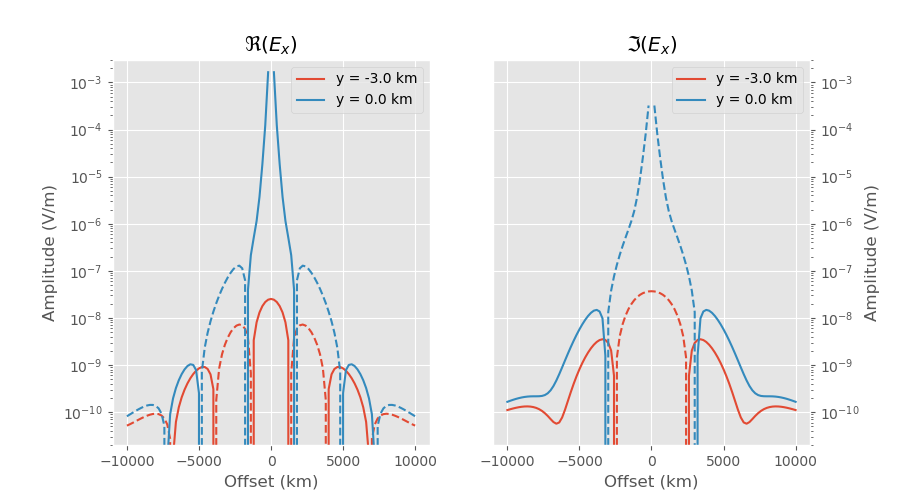

In [6]:
plt.figure(figsize=(9, 5))

# Real
ax1 = plt.subplot(121)
plt.title(r'$\Re(E_x)$')
for i, y in enumerate(rec_y[:2]):
    plt.plot(rec_x, epm_1d[:, i].real, f'C{i}-', label=f'y = {y/1e3} km')
    plt.plot(rec_x, -epm_1d[:, i].real, f'C{i}--')
    
plt.yscale('log')
plt.legend()
plt.xlabel('Offset (km)')
plt.ylabel('Amplitude (V/m)')

# Imaginary
ax2 = plt.subplot(122, sharey=ax1)
plt.title(r'$\Im(E_x)$')
for i, y in enumerate(rec_y[:2]):
    plt.plot(rec_x, epm_1d[:, i].imag, f'C{i}-', label=f'y = {y/1e3} km')
    plt.plot(rec_x, -epm_1d[:, i].imag, f'C{i}--')

plt.ylim([2e-11, 3e-3])
plt.legend()
plt.xlabel('Offset (km)')
plt.ylabel('Amplitude (V/m)')

ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right')

plt.show()

## Save `empymod`-data

In [7]:
survey.line_1.data = epm_1d[:, 0]
survey.line_2.data = epm_1d[:, 1]
survey.line_3.data = epm_1d[:, 2]

# Add meta data
survey.attrs['date'] = datetime.today().isoformat()   # Date
survey.attrs['meta'] = empymod.Report(xr).__repr__()  # Versions and machine info

# Save it under <{model}_{code}.nc>
survey.to_netcdf(f'../results/layered_empymod.nc', invalid_netcdf=True, engine='h5netcdf')

In [8]:
empymod.Report(xr)

--------------------------------------------------------------------------------
  Date: Tue Mar 17 18:12:32 2020 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 7.7 GB
       Environment : Jupyter

  Python 3.7.6 (default, Jan  8 2020, 19:59:22)  [GCC 7.3.0]

            xarray : 0.15.0
             numpy : 1.18.1
             scipy : 1.4.1
             numba : 0.48.0
           empymod : 2.0.0rc2.dev2+gccc7829
           IPython : 7.12.0
        matplotlib : 3.1.3

  Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------